In [0]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## 1. Download data from http://cs231n.stanford.edu/tiny-imagenet-200.zip
## 2. unzip it once
## 3. List the dir on which it is unzipped
## 4. Need not download, unzip data once again.
## 
!ls /content/gdrive/'My Drive'/EIP3 #tiny-imagenet-200/tiny-imagenet-200
!wget -P /content/gdrive/'My Drive'/EIP3 http://cs231n.stanford.edu/tiny-imagenet-200.zip


1x1_convolution.png  conv3x3.gif  convolution.gif  kernel.png
--2019-03-23 18:48:59--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘/content/gdrive/My Drive/EIP3/tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  43.1MB/s    in 5.7s    

2019-03-23 18:49:04 (41.7 MB/s) - ‘/content/gdrive/My Drive/EIP3/tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!ls /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [0]:
!unzip -qq /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200.zip -d /content/gdrive/'My Drive'/EIP3/
!ls /content/gdrive/'My Drive'/EIP3/tiny-imagenet-200


test  train  val  wnids.txt  words.txt


In [0]:
# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing


Using TensorFlow backend.


In [0]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator

# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator( #rescale= 1./255)
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)


In [0]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/", target_size=(64,64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 9997 images belonging to 200 classes.


In [0]:
X_train, Y_train = next(train_generator)
X_train.shape



(128, 64, 64, 3)

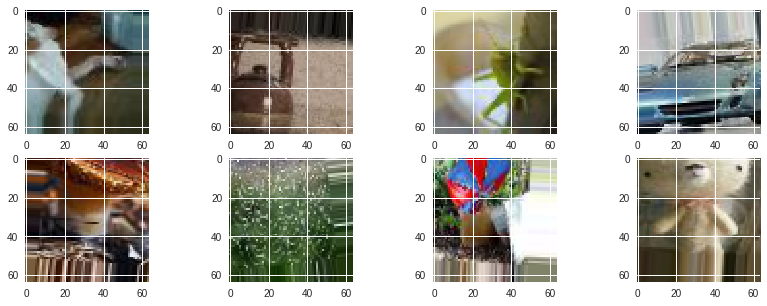

In [0]:
# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(X_train[i,:,:], interpolation='nearest')

In [0]:
X_test, Y_test = next(validation_generator)
X_test.shape

(128, 64, 64, 3)

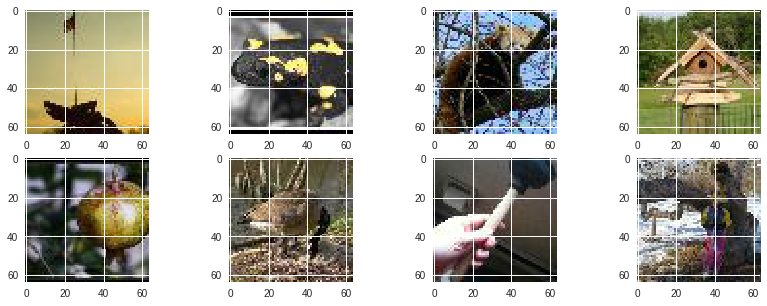

In [0]:

# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(X_test[i,:,:], interpolation='nearest')

In [0]:
# Disclaimer: Below is base ResNet code was donwloaded from https://github.com/raghakot/keras-resnet
# 
# 
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.layers import SeparableConv2D
from keras.layers import GlobalAveragePooling2D

def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        #conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(3, 3), strides=(1, 1))(input)
        conv1 = _conv_bn_relu(filters=128, kernel_size=(3, 3), strides=(1, 1))(conv1)
        conv1 = _conv_bn_relu(filters=256, kernel_size=(3, 3), strides=(1, 1))(conv1)
        
        
        #conv1 = SeparableConv2D(64, 3, depth_multiplier=3,strides=(1, 1),activation='relu' )(input)
        #conv1 = SeparableConv2D(128, 3, depth_multiplier=3,strides=(1, 1),activation='relu' )(conv1)
        #conv1 = SeparableConv2D(256, 3, depth_multiplier=3,strides=(1, 1),activation='relu' )(conv1)
        #conv1 = SeparableConv2D(512, 3, depth_multiplier=3,strides=(1, 1),activation='relu' )(conv1)
        
        
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        
        #X = GlobalAveragePooling2D(data_format='channels_last')(x)
        #X = ACtivation('softmax')(X)

        #flatten1 = Flatten()(pool2)
        #dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                     #activation="softmax")(flatten1)
        
        conv_1_1 = Conv2D(filters=1024, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(pool2)
        conv_1_1 = _bn_relu(conv_1_1)
        ''' '''
        conv_1_1 = Conv2D(filters=512, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(pool2)
        conv_1_1 = _bn_relu(conv_1_1)
        
                
        conv_1_1 = Conv2D(filters=200, kernel_size=(1,1),
                      strides=(1,1), padding="same",
                      kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(conv_1_1)
        conv_1_1 = _bn_relu(conv_1_1)
        X = GlobalAveragePooling2D(data_format='channels_last')(conv_1_1)
        X = Activation('softmax')(X)
        #flatten1 = Flatten()(conv_1_1)

        model = Model(inputs=input, outputs=X)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

In [0]:
import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34.hdf5"
model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_arch.png"
!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet34_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=3)

resnet18_model.json  resnet34_arch.png	resnet34.h5


In [0]:
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

resnet34_arch.png  resnet34.h5


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [0]:
from keras.optimizers import SGD
epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 128
model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 64, 64, 64)   1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 64, 64, 64)   256         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_79 (Activation)      (None, 64, 64, 64)   0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
conv2d_86 

In [0]:
# fit model
model_json = model.to_json()
with open(model_arch_path, "w") as json_file:
    json_file.write(model_json)
print("Saved model to disk")    

model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=(train_generator.n//batch_size),
                    validation_steps=(validation_generator.n//batch_size), validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

# Save Model weight and Architecture in a separate files
# serialize model to JSON
# serialize weights to HDF5
model.save_weights(model_weights_path)
print("Saved model to disk")

Saved model to disk
Epoch 1/500
781/781 [==============================] - 23401s 30s/step - loss: 6.9192 - acc: 0.0455 - val_loss: 6.9445 - val_acc: 0.0532
Epoch 2/500
781/781 [==============================] - 860s 1s/step - loss: 6.3622 - acc: 0.1057 - val_loss: 6.7180 - val_acc: 0.0805
Epoch 3/500
781/781 [==============================] - 861s 1s/step - loss: 5.9650 - acc: 0.1538 - val_loss: 6.1019 - val_acc: 0.1323

Epoch 00003: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0003.hdf5
Epoch 4/500
781/781 [==============================] - 861s 1s/step - loss: 5.6399 - acc: 0.1952 - val_loss: 5.6771 - val_acc: 0.1838
Epoch 5/500
781/781 [==============================] - 862s 1s/step - loss: 5.4165 - acc: 0.2277 - val_loss: 5.7696 - val_acc: 0.1712
Epoch 6/500
781/781 [==============================] - 863s 1s/step - loss: 5.2952 - acc: 0.2443 - val_loss: 6.0589 - val_acc: 0.1369

Epoch 00006: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0006.hdf5
Epoch 7/5

# Iteration2
### Resnet34 customized architecture experimented with 15 epoch and scored highest validation accuracy as 25%. Restarting same architecture with previous check ppint in iteration2.

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/'My Drive'/EIP3

1x1_convolution.png  convolution.gif  resnet34		 tiny-imagenet-200.zip
conv3x3.gif	     kernel.png       tiny-imagenet-200


In [4]:
# Define Imports

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

Using TensorFlow backend.


In [5]:
# Loading validation annotation & extract class labels
val_data = pd.read_csv(r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/val_annotations.txt", sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Loading images as batches using ImageDataGenerator

# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator( #rescale= 1./255)
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=10,
    horizontal_flip=True
    )

valid_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_generator = train_datagen.flow_from_directory( r"/content/gdrive/My Drive/EIP3/tiny-imagenet-200/train/", target_size=(64,64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [11]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='/content/gdrive/My Drive/EIP3/tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=128, shuffle=True, seed=42)

Found 10000 images belonging to 200 classes.


In [12]:
import os
checkpoint_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-{epoch:04d}.hdf5"
model_save_path = "/content/gdrive/My Drive/EIP3/resnet34/resnet34.hdf5"
model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_arch.png"
!mkdir -p /content/gdrive/'My Drive'/EIP3/resnet34/
!ls /content/gdrive/'My Drive'/EIP3/resnet34/

model_weights_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_weights.h5"
model_arch_path =  "/content/gdrive/My Drive/EIP3/resnet34/resnet18_model.json"


# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 period=1)

cp-0009.hdf5  resnet18_model.json  resnet34.h5
cp-0015.hdf5  resnet34_arch.png    resnet34_model.json


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
# You are using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
#clr_triangular = CyclicLR(mode='triangular')
#model.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])
clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='triangular2')

In [15]:


#

from keras.models import model_from_json
# model.load_weights
# load json and create model
# Iteration1 Model loading
iter1_model_arch = "/content/gdrive/My Drive/EIP3/resnet34/resnet34_model.json"
json_file = open(iter1_model_arch, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("Loaded model arch fron json")

# load weights into new model
# Since previous model does not complete, loading latest check point weight
chk_point_weight_path = "/content/gdrive/My Drive/EIP3/resnet34/cp-0015.hdf5"
loaded_model.load_weights(chk_point_weight_path)
print("Loaded model weights from previous iteration ")


Loaded model arch fron json
Loaded model weights from previous iteration 


In [0]:
from keras.optimizers import SGD
epochs=500
img_channels=3
img_rows=64
img_cols=64
nb_classes = 200
batch_size = 256
#model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loaded_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

#model.summary()

In [0]:
# fit model
#model_json = loaded_model.to_json()
#with open(model_arch_path, "w") as json_file:
#    json_file.write(model_json)
#print("Saved model to disk")    

loaded_model.fit_generator(train_generator, epochs=epochs, initial_epoch=15,
                           steps_per_epoch=(train_generator.n//batch_size),
                    validation_steps=(validation_generator.n//batch_size), validation_data=validation_generator,
                    callbacks=[cp_callback,clr])

# Save Model weight and Architecture in a separate files
# serialize model to JSON
# serialize weights to HDF5
model.save_weights(model_weights_path)
print("Saved model to disk")

Instructions for updating:
Use tf.cast instead.
Epoch 16/500
390/390 [==============================] - 22931s 59s/step - loss: 4.5004 - acc: 0.3641 - val_loss: 5.2691 - val_acc: 0.2468

Epoch 00016: saving model to /content/gdrive/My Drive/EIP3/resnet34/cp-0016.hdf5
Epoch 17/500
303/390 [======================>.......] - ETA: 1:19:45 - loss: 4.5368 - acc: 0.3552